<a href="https://colab.research.google.com/github/seldonian-toolkit/Tutorials/blob/main/tutorial_d_fairness_for_automated_loan_approval_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contents

*   <a href="#introduction">Introduction</a>
*   <a href="#outline">Outline</a>
*   <a href="#install">Install Seldonian libraries</a>
*   <a href="#dataset_prep">Dataset preparation</a>
*   <a href="#formulate">Formulate the Seldonian ML problem</a>
*   <a href="#spec_object">Creating the specification object</a>
  *  <a href="#spec_from_script">Creating the specification object from a script</a>
  *  <a href="#spec_from_gui">Creating the specification object from the Seldonian Interface GUI</a>
*   <a href="#running_the_engine">Running the Seldonian Engine</a>
  *  <a href="#gradient_descent">Understanding and visualizing gradient descent</a>
*   <a href="#experiments">Running a Seldonian Experiment</a>
  * <a href="#terms"> Defining terms for the experiment</a>
  * <a href="#exp_outline"> Outline of the experiment</a>
  * <a href="#exp_implement"> Implementing the experiment</a>
  * <a href="#modifying_the_constraint">Modifying the constraint to line up with Fairlearn's constraint</a>
*   <a href="#summary">Summary</a>



<a name="introduction"></a>
## Introduction
This tutorial is intended to provide an end-to-end use case of the Seldonian Toolkit. The engine supports regression and classification Seldonian algorithms in the supervised learning regime. We will be using the <a href="https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)">UCI Statlog (German Credit Data) Data Set</a>, which contains 20 attributes for a set of 1000 people and a binary-valued label column describing whether they are a high (value=1) or low credit risk (value=0). If someone is a high credit risk, a bank is less likely to provide them with a loan. Our goal in this tutorial will be to use the Seldonian Toolkit to create a model that makes predictions about credit risks that are fair with respect to gender (for this tutorial we consider the simplified binary gender setting). We will use several definitions of fairness, and we stress that these definitions may not be the correct ones to use in reality. They are simply examples to help you understand how to use this toolkit. Note that due to the choice of confidence-bound method used in this tutorial (Student's $t$-test), the algorithms in this tutorial are technically quasi-Seldonian algorithms (QSAs).

<a name="outline"></a>
## Outline
In this tutorial, you will learn how to:


*  Format a supervised learning (classification) dataset so that it can be used in the Seldonian Toolkit.
*  Build a Seldonian machine learning model that implements common fairness constraints.
* Run a Seldonian Experiment, assessing the performance and safety of the Seldonian ML model relative to baseline models and other fairness-aware ML models.







<a name="install"></a>
## Install Seldonian libraries

In [1]:
# first check Python version. Needs to be Python >= 3.8
!python --version

Python 3.8.16


In [3]:
# This command will install the engine and the experiments library
!pip install seldonian-experiments==0.0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: seldonian-experiments
    Found existing installation: seldonian-experiments 0.0.11
    Uninstalling seldonian-experiments-0.0.11:
      Successfully uninstalled seldonian-experiments-0.0.11


If after running the install commands you see a note about restarting the runtime in order to use newly installed versions above, click the "restart runtime" button to do that. Otherwise, the plotting below may not work as expected. You don't need to re-run the above pip install command after restarting the runtime.

<a name="dataset_prep"></a>
## Dataset preparation
UCI provides two versions of the dataset: "german.data" and "german.data-numeric". They also provide a file "german.doc" describing the "german.data" file only. We ignored the "german.data-numeric" file because there was no documentation for it. We downloaded the file "german.data" from here: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/">https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/</a>. We converted it to a CSV file by replacing the space characters with commas. We saved the modified CSV file to a github repo, and we show how to import it into this notebook below.

We need to do some data preprocessing on this file to get it into a format we can work with in the Seldonian libraries. Specifically, the Seldonian Engine has these requirements in order to import a supervised learning data file: 

*  The columns must be numeric
*  The sensitive attributes must be one-hot encoded. For example, if we have a race attribute with three possible values (A,B,C), we need to expand this into three columns, where column A has a value of 1 if the race is A, 0 otherwise, column B has a value of 1 if the race is B, 0 otherwise, etc...
* If we use the Engine's data loader, we'll want to keep all of the data including the features, labels and sensitive attributes in a single data file. If we don't use the Engine's data loader, we can keep these separate. They get separated in the Engine's DataSet object regardless of the loading method. 

First, let's import the packages we will need.

In [4]:
import requests, io
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from seldonian.utils.io_utils import save_json

Here we fetch the CSV file we are going to start with and read it into a pandas dataframe.

In [5]:
file_url = "https://raw.githubusercontent.com/seldonian-toolkit/Engine/main/examples/loan_tutorial/german.csv"

r = requests.get(file_url)
if r.ok:
    data = r.content.decode('utf8')
datastring = io.StringIO(data)
columns_orig = [
    "account_status","months","credit_history",
    "purpose","credit_amount","savings_accounts",
    "employment_since","installment_rate","personal_status",
    "other_debtors","present_residence_since","property",
    "age_yrs","other_installment_plans","housing",
    "num_existing_credits","job","num_people_liable",
    "telephone","foreign_worker","credit_rating"]
df = pd.read_csv(datastring,header=None,names=columns_orig)

In [6]:
df.head()

,account_status,months,credit_history,purpose,credit_amount,savings_accounts,employment_since,installment_rate,personal_status,other_debtors,...,property,age_yrs,other_installment_plans,housing,num_existing_credits,job,num_people_liable,telephone,foreign_worker,credit_rating
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


The column called "personal status" (column 9) according to "german.doc", is the personal status/sex of each person. This is a categorical column with 5 possible values, 2 of which describe females and 3 of which describe males. We created a new column that has a value of "F" if female (A92 or A95) and "M" if male (any other value). We ignored the personal status of the person for the purpose of this tutorial. 

In [7]:
# split into inputs and outputs
X = df.drop(columns=["credit_rating"])
y = df["credit_rating"]

# Need to make male and female columns from personal status column and then remove the personal_status column
# A91, A93 and A94 are male and A92, A95 are female
female_mask = np.logical_or(X['personal_status']=='A92',X['personal_status']=='A95')
X.loc[female_mask,'personal_status'] = "F"
X.loc[~female_mask,'personal_status'] = "M"

# rename column to sex
X.rename(columns={'personal_status':'sex'},inplace=True)

Next, we one-hot encode all thirteen categorical features, including the sex feature that we created in the previous step. We apply a standard scaler to the remaining numerical 7 features. The one-hot encoding step creates an additional 39 columns, resulting in 59 total features. The final column in the dataset, the "credit_rating", is the label. We map the values of this column as such: (1,2) -> (0,1) so that they will behave well in our binary classification models. We combine the 59 features and the single label column into a single pandas dataframe and save the file as a CSV file. A copy of this file can be found <a href="https://github.com/seldonian-toolkit/Engine/blob/main/static/datasets/supervised/german_credit/german_loan_numeric_forseldonian.csv">here</a>.

In [8]:
# select categorical features and numerical features
cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns

# one hot encode cat features only, scale numerical features using standard scaler 
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',StandardScaler(),num_ix)])

# Apply transformation
X = ct.fit_transform(X)

# label encode the target variable to have the classes 0 and 1
# 0 is good credit, 1 is bad credit
y = LabelEncoder().fit_transform(y)

# Get names after one-hot encoding
output_columns = ct.get_feature_names_out(ct.feature_names_in_)

# Make an output dataframe to save from X and y
outdf = pd.DataFrame(X,columns=output_columns)

# Change name of the two one-hot encoded sex columns to M and F
outdf.rename(columns={'c__sex_F':'F','c__sex_M':'M'},inplace=True)

# Add label column into final dataframe
outdf['credit_rating'] = y

In [9]:
outdf

,c__account_status_A11,c__account_status_A12,c__account_status_A13,c__account_status_A14,c__credit_history_A30,c__credit_history_A31,c__credit_history_A32,c__credit_history_A33,c__credit_history_A34,c__purpose_A40,...,c__foreign_worker_A201,c__foreign_worker_A202,n__months,n__credit_amount,n__installment_rate,n__present_residence_since,n__age_yrs,n__num_existing_credits,n__num_people_liable,credit_rating
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,1
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.738668,-0.544162,0.024147,1.046987,-0.399832,-0.704926,-0.428290,0
996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.754763,0.207612,0.918477,1.046987,0.391740,-0.704926,-0.428290,0
997,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.738668,-0.874503,0.918477,1.046987,0.215835,-0.704926,-0.428290,0
998,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.999289,-0.505528,0.918477,1.046987,-1.103451,-0.704926,-0.428290,1


In [10]:
# Save final dataframe
output_path_data = "german_loan_numeric_forseldonian.csv"
outdf.to_csv(output_path_data,index=False,header=False)
print(f"Saved data file to: {output_path_data}")
print()

Saved data file to: german_loan_numeric_forseldonian.csv



We also create a dictionary containing the metadata that we will need to provide to the Seldonian Engine library. The column names beginning with "c__" were the columns created by scikit-learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">OneHotEncoder</a>. The columns "M" and "F" are somewhat buried in the middle of the columns list and correspond to the male and female one-hot encoded columns. The "sensitive_columns" key in the dictionary points to those columns. The "label_column" key in the dictionary points to the "credit_rating" column. We save this dictionary to a JSON file, a copy of which can be found <a href="https://github.com/seldonian-toolkit/Engine/blob/main/static/datasets/supervised/german_credit/metadata_german_loan.json">here</a>.

In [11]:
# create metadata json
output_path_metadata="metadata_german_loan.json"
metadata_dict = {
    "regime":"supervised_learning",
    "sub_regime":"classification",
    "all_col_names":list(outdf.columns),
    "label_col_names":["credit_rating"],
    "sensitive_col_names":["F","M"]
}
metadata_dict

{'regime': 'supervised_learning',
 'sub_regime': 'classification',
 'all_col_names': ['c__account_status_A11',
  'c__account_status_A12',
  'c__account_status_A13',
  'c__account_status_A14',
  'c__credit_history_A30',
  'c__credit_history_A31',
  'c__credit_history_A32',
  'c__credit_history_A33',
  'c__credit_history_A34',
  'c__purpose_A40',
  'c__purpose_A41',
  'c__purpose_A410',
  'c__purpose_A42',
  'c__purpose_A43',
  'c__purpose_A44',
  'c__purpose_A45',
  'c__purpose_A46',
  'c__purpose_A48',
  'c__purpose_A49',
  'c__savings_accounts_A61',
  'c__savings_accounts_A62',
  'c__savings_accounts_A63',
  'c__savings_accounts_A64',
  'c__savings_accounts_A65',
  'c__employment_since_A71',
  'c__employment_since_A72',
  'c__employment_since_A73',
  'c__employment_since_A74',
  'c__employment_since_A75',
  'F',
  'M',
  'c__other_debtors_A101',
  'c__other_debtors_A102',
  'c__other_debtors_A103',
  'c__property_A121',
  'c__property_A122',
  'c__property_A123',
  'c__property_A124',

In [12]:
# save metadata to json file
with open(output_path_metadata,'w') as outfile:
    json.dump(metadata_dict,outfile,indent=2)
print(f"Saved metadata file to: {output_path_metadata}")

Saved metadata file to: metadata_german_loan.json


<a name="formulate"></a>
## Formulate the Seldonian ML problem

As in the <a href="{{ page.prev_url | relative_url }}">previous tutorial</a>, we first need to define the standard machine learning problem in the absence of constraints. The decision of whether to deem someone as being a high or low credit risk is a binary classification problem, where the label "credit_rating" is 0 if the person is a low credit risk and 1 if the person is a high credit risk. We could use logistic regression and minimize an objective function, for example the logistic loss, via gradient descent to solve this standard machine learning problem.  


Now, let's suppose we want to add fairness constraints to this problem. The first fairness constraint that we will consider is called <i>disparate impact</i>, which ensures that the ratio of positive class predictions (in our case, the prediction that someone is a high credit risk) between sensitive groups may not differ by more than some threshold. In the <a href="{{ page.prev_url | relative_url }}">previous tutorial</a>, we demonstrated how to write fairness constraints for a regression problem using the special measure function "Mean_Squared_Error" in the constraint string. For disparate impact, the measure function we will use is "PR", which stands for "positive rate", which is the fraction of predictions that predict 1, the positive class. Disparate impact between our two sensitive attribute columns "M" and "F" with a threshold value of 0.9 can be written as: $\text{min}( (\text{PR} | [\text{M}]) / (\text{PR} | [\text{F}]), (\text{PR} | [\text{F}]) / (\text{PR} | [\text{M}]) ) \geq 0.9$.
Let us enforce this constraint function with a confidence of $0.95$. 

The problem can now be fully formulated as a Seldonian machine learning problem:

> Using gradient descent on a logistic model, minimize the logistic loss, subject to the constraint:

$$g_{1}: \mathrm{min}( (\text{PR} | [\text{M}])/(\text{PR} | [\text{F}]),(\text{PR} | [\text{F}]) / (\text{PR} | [\text{M}]) ) \geq 0.9$, and ${\delta}_1=0.05$$ 

<a name="spec_object"></a>
## Creating the specification object

To run the Seldonian algorithm using the Seldonian Toolkit libraries, we will need to create a <a href="https://seldonian-toolkit.github.io/Engine/build/html/_autosummary/seldonian.spec.SupervisedSpec.html#seldonian.spec.SupervisedSpec">SupervisedSpec</a> object. We will demonstrate two different ways to create this object for our example problem. 

<a name="spec_from_script"></a>
### Creating the specification object from a script 

A complete script for creating the spec object for our Seldonian ML problem is shown below. This script will save the spec object as a pickle file called "spec.pkl" in the `save_dir` directory on your computer. That directory is currently set to `.`, the current directory. If working on a local machine (outside of Google Colab), change `save_dir` in the code snippet below to the directory where you want to save the spec file. Also, make sure to modify `data_pth` and `metadata_pth` to point to the locations where you saved the data and metadata files described in the <a href="#dataset_prep"> Dataset preparation section</a>, respectively. If working in Colab, you won't need to change these paths. 


In [13]:
import autograd.numpy as np
import os
from seldonian.parse_tree.parse_tree import (ParseTree,
    make_parse_trees_from_constraints)

from seldonian.dataset import DataSetLoader
from seldonian.utils.io_utils import (load_json,save_pickle)
from seldonian.spec import SupervisedSpec
from seldonian.models.models import (
    BinaryLogisticRegressionModel as LogisticRegressionModel) 
from seldonian.models import objectives

data_pth = "german_loan_numeric_forseldonian.csv"
metadata_pth = "metadata_german_loan.json"
save_dir = '.'
os.makedirs(save_dir,exist_ok=True)
# Create dataset from data and metadata file
regime='supervised_learning'
sub_regime='classification'

loader = DataSetLoader(
    regime=regime)

dataset = loader.load_supervised_dataset(
    filename=data_pth,
    metadata_filename=metadata_pth,
    file_type='csv')
sensitive_col_names = dataset.meta_information['sensitive_col_names']

# Use logistic regression model
model = LogisticRegressionModel()

# Set the primary objective to be log loss
primary_objective = objectives.binary_logistic_loss

# Define behavioral constraints
constraint_strs = ['min((PR | [M])/(PR | [F]),(PR | [F])/(PR | [M])) >= 0.9'] 
deltas = [0.05]

# For each constraint (in this case only one), make a parse tree
parse_trees = make_parse_trees_from_constraints(
    constraint_strs,deltas,regime=regime,
    sub_regime=sub_regime,columns=sensitive_col_names)

# Save spec object, using defaults where necessary
spec = SupervisedSpec(
    dataset=dataset,
    model=model,
    parse_trees=parse_trees,
    sub_regime=sub_regime,
    frac_data_in_safety=0.6,
    primary_objective=primary_objective,
    initial_solution_fn=model.fit,
    use_builtin_primary_gradient_fn=True,
    optimization_technique='gradient_descent',
    optimizer='adam',
    optimization_hyperparams={
        'lambda_init'   : np.array([0.5]),
        'alpha_theta'   : 0.01,
        'alpha_lamb'    : 0.01,
        'beta_velocity' : 0.9,
        'beta_rmsprop'  : 0.95,
        'use_batches'   : False,
        'num_iters'     : 1500,
        'gradient_library': "autograd",
        'hyper_search'  : None,
        'verbose'       : True,
    }
)

spec_save_name = os.path.join(save_dir,'spec.pkl')
save_pickle(spec_save_name,spec)
print(f"Saved Spec object to: {spec_save_name}")

Saved Spec object to: ./spec.pkl


Let's take a close look at the instantiation of `SupervisedSpec` in the code above so we can understand each of the arguments. First, the spec object takes the `dataset` and `model` objects as arguments. Next, we pass the `parse_trees` list that we defined above in the script. In our case, we only have one parse tree (because there is one parse tree per constraint), but it still must be passed as a list. We also need to pass the `sub_regime` to indicate the type of supervised ML problem. Then, we set `frac_data_in_safety=0.6`, which specifies that 60% of the data points in our dataset will be used for the safety test. The remaining 40% of the points will be used for candidate selection. Next, we specify the `primary_objective` function, followed by the `initial_solution_fn`, which specifies the function we will use to provide the initial solution to candidate selection. Here, we set `initial_solution_fn=model.fit`.  Because `model` refers to our `LogisticRegressionModel()` object, `model.fit` refers to that objects' `fit` method. This method is just a wrapper for  <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit">scikit-learn's LogisticRegression fit method</a>. The reason we use this method to create an initial solution is so that we start gradient descent with model weights that minimize the primary objective (in the absence of constraints). Because we have constraints, this initial solution is not necessarily the true optimum of our optimization problem, but it can help us find the true optimum much more efficiently in some cases. 

The next argument is `use_builtin_primary_gradient_fn=True`. This instructs the engine to use a function that is already part of the library to calculate the gradient of the primary objective. Recall that earlier in the script we set the primary objective to be the logistic loss with the line: `primary_objective = objectives.binary_logistic_loss`. Built-in gradients exist for some common objective functions (see <a href="https://github.com/seldonian-toolkit/Engine/blob/main/seldonian/models/models.py">https://github.com/seldonian-toolkit/Engine/blob/main/seldonian/models/models.py</a>), including the binary logistic loss. If you use a custom primary objective function, there will definitely not be a built-in gradient function for your objective (unless you specify one) and `use_builtin_primary_gradient_fn=True` will raise an error. Setting `use_builtin_primary_gradient_fn=False` will cause the engine to use automatic differentiation to calculate the gradient of the primary objective instead. While automatic differentiation will work, using a built-in function for the gradient can speed up execution in some cases. There is also a parameter for specifying a custom function for the gradient of the primary objective as well, but we will not cover that in this tutorial. 

The next argument is `optimization_technique='gradient_descent'`, which specifies how we will search for a candidate solution during candidate selection. The other option for this argument is `barrier_function'`, which we will not cover here. The argument `optimizer='adam'` instructs the code to use the Adam optimizer during gradient descent. The final argument, `optimization_hyperparams`, is for setting the parameters of gradient descent, which include:

*  `'lambda_init'`: the initial value of the Lagrange multiplier. 
*  `'alpha_theta'`: the initial learning rate for the model parameters. 
*  `'alpha_lamb'`: the initial learning rate for the Lagrange multiplier. 
*  `'beta_velocity'`: the decay rate of the velocity (also called momentum) term. 
*  `'beta_rmsprop'`: the decay rate of the rmsprop term. 
*  `'use_batches'`: whether to use mini batches for gradient descent. In our case we're not going to use batches.
*  `'num_iters'`: the number of iterations of gradient descent to run. This is only used if `'use_batches'` is `False`. Otherwise, the batch size and number of epochs determine the number of iterations. 
*  `'gradient_library'`: the library to use for calculating gradients automatically. Currently "autograd" is the only option. 
*  `'hyper_search'`: how to conduct search over hyperparameters. Set to None which does not perform a search. 
*  `'verbose'`: whether to print out iteration progress during gradient descent. 

For more details about the `SupervisedSpec` object, see the <a href="https://seldonian-toolkit.github.io/Engine/build/html/_autosummary/seldonian.spec.SupervisedSpec.html">engine docs </a>.

<a name="spec_from_gui"></a>
### Creating the specification object from the Seldonian Interface GUI


The instructions for using the Seldonian Interface GUI are described: <a href="https://seldonian-toolkit.github.io/GUI/build/html/index.html">here</a>. Once you have started up the GUI, scroll down to the "Data and metadata setup" section. Upload the data file you downloaded in the <a href="#dataset_prep"> Dataset preparation section</a> above in the "Data file" field of the form. For convenience, here is the file you need to upload: <a href="https://github.com/seldonian-toolkit/Engine/blob/main/static/datasets/supervised/german_credit/german_loan_numeric_forseldonian.csv">https://github.com/seldonian-toolkit/Engine/blob/main/static/datasets/supervised/german_credit/german_loan_numeric_forseldonian.csv</a>. Then select the "supervised_learning" regime and "classification" sub-regime from the drop-downs in that section. Copy and paste the following text string into the "All attributes" field: 


> c__account_status_A11,c__account_status_A12,c__account_status_A13,c__account_status_A14,c__credit_history_A30,c__credit_history_A31,c__credit_history_A32,c__credit_history_A33,c__credit_history_A34,c__purpose_A40,c__purpose_A41,c__purpose_A410,c__purpose_A42,c__purpose_A43,c__purpose_A44,c__purpose_A45,c__purpose_A46,c__purpose_A48,c__purpose_A49,c__savings_accounts_A61,c__savings_accounts_A62,c__savings_accounts_A63,c__savings_accounts_A64,c__savings_accounts_A65,c__employment_since_A71,c__employment_since_A72,c__employment_since_A73,c__employment_since_A74,c__employment_since_A75,F,M,c__other_debtors_A101,c__other_debtors_A102,c__other_debtors_A103,c__property_A121,c__property_A122,c__property_A123,c__property_A124,c__other_installment_plans_A141,c__other_installment_plans_A142,c__other_installment_plans_A143,c__housing_A151,c__housing_A152,c__housing_A153,c__job_A171,c__job_A172,c__job_A173,c__job_A174,c__telephone_A191,c__telephone_A192,c__foreign_worker_A201,c__foreign_worker_A202,n__months,n__credit_amount,n__installment_rate,n__present_residence_since,n__age_yrs,n__num_existing_credits,n__num_people_liable,credit_rating

This is the list of all of the columns in the dataset, including the sensitive attributes and the label column. Enter <code>M,F</code> into the "Sensitive attributes" field and <code>credit_rating</code> into the "Label column" field.

Scroll down to the "Constraint building blocks" area and click the "Disparate impact" button. This will auto-fill Constraint #1 with a preconfigured constraint for disparate impact, which will have the form that we defined above. The one change you will need to make is to remove the constant block titled "0.8" and create a new constant block titled "0.9". Drag the new constant block into the constraint so that it becomes solid. Type 0.05 into the field titled "${\delta} = $" just below where the constraint function was auto-filled. Then hit the submit button. A dialog box should show up displaying: "Saved ./spec.pkl", which indicates that the specification object has been saved as a pickle file to the directory where you launched the GUI. 

<a name="running_the_engine"></a>
## Running the Seldonian Engine 
We are now ready to run the Seldonian algorithm using the spec object generated in the previous step, regardless of the method used. The code below loads the spec object from the file and then runs the Seldonian algorithm using the spec object. 

In [14]:
import os

from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.utils.io_utils import load_pickle

# Load loan spec file
specfile = './spec.pkl'
spec = load_pickle(specfile)
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(write_cs_logfile=True)
if passed_safety:
    print("Passed safety test!")
else:
    print("Failed safety test")

Safety dataset has 600 datapoints
Candidate dataset has 400 datapoints
Have 1500 epochs and 1 batches of size 400 for a total of 1500 iterations
Epoch: 0, batch iteration 0
Epoch: 1, batch iteration 0
Epoch: 2, batch iteration 0
Epoch: 3, batch iteration 0
Epoch: 4, batch iteration 0
Epoch: 5, batch iteration 0
Epoch: 6, batch iteration 0
Epoch: 7, batch iteration 0
Epoch: 8, batch iteration 0
Epoch: 9, batch iteration 0
Epoch: 10, batch iteration 0
Epoch: 11, batch iteration 0
Epoch: 12, batch iteration 0
Epoch: 13, batch iteration 0
Epoch: 14, batch iteration 0
Epoch: 15, batch iteration 0
Epoch: 16, batch iteration 0
Epoch: 17, batch iteration 0
Epoch: 18, batch iteration 0
Epoch: 19, batch iteration 0
Epoch: 20, batch iteration 0
Epoch: 21, batch iteration 0
Epoch: 22, batch iteration 0
Epoch: 23, batch iteration 0
Epoch: 24, batch iteration 0
Epoch: 25, batch iteration 0
Epoch: 26, batch iteration 0
Epoch: 27, batch iteration 0
Epoch: 28, batch iteration 0
Epoch: 29, batch iterati

We can see that the solution found passed the safety test. Now let's calculate what the value of the primary objective function (log loss) is on the safety dataset, using the solution found by the Seldonian algorithm:

In [15]:
print("Primary objective (log loss) evaluated on safety dataset:")
print(SA.evaluate_primary_objective(branch='safety_test',theta=solution))

Primary objective (log loss) evaluated on safety dataset:
0.5818282881571583


Note the line saying: 
```bash
Wrote /content/logs/candidate_selection_log0.p with candidate 
```
This is a pickle file containing the values of various parameters during each step of the gradient descent algorithm that was run during candidate selection. *italicized text*

<a name='gradient_descent'></a>
### Understanding and visualizing gradient descent

The pickle file mentioned in the previous section contains a dictionary with the values of many of the parameters relevant to gradient descent. This dictionary is also retrievable via the <a href="https://seldonian-toolkit.github.io/Engine/build/html/_autosummary/seldonian.seldonian_algorithm.SeldonianAlgorithm.html#seldonian.seldonian_algorithm.SeldonianAlgorithm.get_cs_result">SA.get_cs_result()</a> method, e.g.,

In [16]:
cs_dict = SA.get_cs_result() # returns a dictionary with a lot of quantities evaluated at each step of gradient descent

In [17]:
# Print all of the keys of this dictionary:
print(list(cs_dict.keys()))


['candidate_solution', 'best_index', 'best_f', 'best_g', 'best_lamb', 'best_L', 'found_feasible_solution', 'theta_vals', 'f_vals', 'lamb_vals', 'g_vals', 'L_vals', 'constraint_strs', 'batch_size', 'n_epochs']


Here we explain what each of these keys represents:


* `candidate_solution` contains the optimal weight vector found during candidate selection. 
* `best_index` is the iteration of gradient descent where the optimum was found. 
* `best_f` is the value of the primary objective function at the optimal gradient descent step, `best_index`. 
* `best_g` is a vector containing the values of the upper bounds on the constraint functions at the optimal gradient descent step, `best_index`. 
* `best_lamb` is a vector containing the values of the Lagrange multipliers at the optimal gradient descent step, `best_index`.
* `best_L` is the value of the Lagrangian at the optimal gradient descent step, `best_index`.
* `found_feasible_solution` is a Boolean indicating whether a solution was found that is predicted to pass the safety test. 
* `theta_vals` is an array containing the model weights $\theta_j$ at each $j$th iteration of gradient descent. 
* `f_vals` is an array containing the value of the primary objective function $f_j$ at each $j$th iteration of gradient descent. 
* `lamb_vals` is an array containing the vector of each $i$th Lagrange multiplier $\lambda_{i,j}$ at each $j$th iteration of gradient descent. 
* `g_vals` is an array containing the vector of each $i$th constraint function upper bound $\text{HCUB}(g_{i,j})$ at each $j$th iteration of gradient descent. 
* `L_vals` is an array containing the values of the Lagrangian $\mathscr{L}_{j}$ at each $j$th iteration of gradient descent. 
* `constraint_strs` is a list of the constraint strings. 
* `batch_size` is the batch size used in gradient descent. 
* `n_epochs` is the number of epochs used in gradient descent. 

So, to get the primary objective values at each iteration of gradient descent (this takes place in candidate selection only), one would do:


In [18]:
print(cs_dict['f_vals'])

[0.403078   0.40403384 0.40958629 ... 0.51922675 0.52031313 0.52055889]


Similarly, to get the value of the upper bound on the constraint function, $\text{HCUB}(g_1)$, at each iteration of gradient descent, one would do:

In [19]:
print(cs_dict['g_vals'])

[[0.41441905]
 [0.39370886]
 [0.36008045]
 ...
 [0.00821224]
 [0.0064562 ]
 [0.00703253]]


In our example here, we only have one constraint, so each vector is of length 1. If candidate selection returns `"NSF"`, the `cs_dict` will still store these values. Note that this particular `cs_dict` is unique to gradient descent. Other optimization techniques will return different structures of the `cs_dict`.

As part of the Engine library, we provide a plotting function that is designed to help visualize the contents of this dictionary (for gradient descent only). The following code will run that function on the file. 

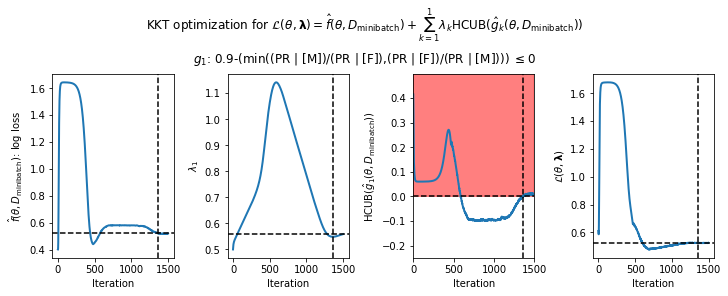

In [20]:
from seldonian.utils.io_utils import load_pickle
from seldonian.utils.plot_utils import plot_gradient_descent
import matplotlib.pyplot as plt

cs_file = '/content/logs/candidate_selection_log0.p'
solution_dict = load_pickle(cs_file)

fig = plot_gradient_descent(solution_dict,
    primary_objective_name='log loss',
    save=False)

The above figure shows how the parameters of the <a href="https://seldonian.cs.umass.edu/Tutorials/tutorials/alg_details_tutorial/#kkt">KKT optimization problem</a> changed during gradient descent on the loan fairness problem. (Left) primary objective function $\hat{f}(\theta,D_\mathrm{minibatch})$ (in this case the log loss), (middle left) single Lagrange multiplier, ${\lambda_1}$, (middle right) predicted high-confidence upper bound (HCUB) on the disparate impact constraint function, $\hat{g}_1(\theta,D_\mathrm{minibatch})$, and (right) the Lagrangian $\mathscr{L}(\theta,\boldsymbol{\lambda})$. $\boldsymbol{\lambda}$ is in bold here because it is a vector in the general case where there are $n$ constraints. The black dotted lines in each panel indicate where the optimum was found. The optimum is defined as the feasible solution with the lowest value of the primary objective. A feasible solution is one that is predicted to pass the safety test, i.e., where $\mathrm{HCUB}(\hat{g}_i(\theta,D_\mathrm{cand})) \leq 0, i \in \{1 ... n\}$. In this example, we only have one constraint, and the infeasible region is shown in red in the middle right plot. The feasible region is the white region at or below 0 in that plot.

This example illustrates a constraint that conflicts with the primary objective function. In the plots, $\hat f$ generally increases whenever $\mathrm{HCUB}(\hat{g}_1)$ increases. That is why the optimal solution is not the one with the lowest value of $\hat f$.

Visualizing candidate selection can help you tune the optimization hyperparameters in your spec object. For example, if your Seldonian algorithm is returning NSF (i.e., "No Solution Found"), then very likely $\theta$ is never escaping the infeasible (red) region. You may be able to obtain a solution by running gradient descent (with the Adam optimizer) for more iterations or with different learning rates or velocity values (the beta terms in Adam). If you are still seeing NSF after hyperparameter exploration, you may not have enough data or your constraints may be too strict. Running a Seldonian Experiment can help determine why you are not able to obtain a solution.

<a name="experiments"></a>
## Running a Seldonian Experiment

Seldonian Experiments are a way to thoroughly evaluate the performance and safety of Seldonian algorithms, beyond what can be achieved with a single run of the engine. A Seldonian Experiment runs a Seldonian algorithm many times using variable amounts of input data and creates three plots: 1) Performance, 2) Probability of solution, and 3) Probability that the constraint was violated. All are plotted as a function of the amount of data used. The <a href="https://seldonian-toolkit.github.io/Experiments"> Seldonian Experiments library</a> was designed to help implement Seldonian Experiments. We recommend reading the <a href="https://seldonian-toolkit.github.io/Experiments/build/html/overview.html">Experiments overview</a> before continuing here. 


Before we dive into running the experiment, let's define some helpful terms.

<a name="terms"></a>
### Defining terms for the experiment
*  The "original dataset" refers to the dataset we used to run the engine above. To calculate performance and the probability that the constraint was violated, we need a ground truth dataset. **To approximate ground truth, we use the original dataset**. While this does not tell you what the performance rate or failure rate will be on your actual problem, it does give a reasonable estimate.
*  A "trial" refers to a single run of the Seldonian Engine. The inputs between different trials can and will vary.
*  A "data fraction" refers to the fraction (a number between 0 and 1) of the number of total data points in the original dataset (1000). 

<a name="exp_outline"></a>
### Outline of the experiment
* Define `n_tot=1000` to be the total number of points in the original dataset
*  Create an array `data_fracs=np.logspace(-3,0,15)`, which contains 15 different data fractions, log-spaced between 0.001 and 1.0. This array times `n_tot` will make up the horizontal axis of each of the three plots.
*  Set `n_trials=50`. We use 50 trials so that we can compute uncertainties on the plotted quantities at each data fraction. 
*  For each of the 50 trials, create a resampled dataset of size `n_tot` by sampling with replacement from the original dataset. This will create 50 resampled datasets containing 1000 datapoints each. Assign a trial number to each of these resampled datasets.
*  For each `data_frac` in `data_fracs`, run `n_trials` trials. For each trial, take the first `data_frac*n_tot` datapoints from the assigned resampled dataset for this trial number and run the engine with these datapoints only. This will generate 15 data fractions x 50 trials = 750 total runs of the engine. Each run will return a solution (model parameters), or "NSF" if no safe solution was found. 
*  For each `data_frac`:
  * For the trials for which a solution was returned that passed the safety test, calculate the performance (in our case logistic loss) of each trial on the original dataset. Calculate the mean and standard error on the performance over these trials. This will be the data used for the first of the three plots. 
  *  Calculate the fraction of trials for which a solution was returned that passed the safety test across the 50 trials. This fraction will be used to make the second of the three plots.
  * For the fraction of trials for which a solution was returned that passed the safety test, calculate the value of the disparate impact statistic, $g_1(\theta)$. Calculate the fraction of those trials for which the disparate impact statistic was violated, i.e., $g_1(\theta) > 0$, on the original dataset. The fraction violated will make up the third and final plot. 

We will run this experiment for the Seldonian algorithm as well as for three other models. Two are baseline models: 1) a random classifier that predicts the positive class with probability $p=0.5$ regardless of the input, 2) a simple logistic regression model with no behavioral constraints. The third model comes from another fairness-aware machine learning library called <a href="https://fairlearn.org/">Fairlearn</a>. We will describe the Fairlearn model in more detail below. 

Each model requires its own experiment, but the main parameters of the experiment, such as the number of trials and data fractions, as well as the metrics we will calculate to make the three plots (performance, probability of solution, and probability that the constraint was violated), must be identical. This will allow us to compare the Seldonian algorithm to these other models on the same three plots. 


<a name="exp_implement"></a>
## Implementing the experiment
Now, we will show how to implement the described experiment using the Experiments library. 

**Note:** Running the following experiments is compute-intensive on the CPU. The experiments library is parallelized across multiple CPUs to speed up the computation. However, free-tier Colab Notebooks such as the default one you may be using lack the number and quality of CPUs for running the experiments in a reasonable amount of time. To avoid having you spend hours waiting for the experiments to finish, we have pre-populated the results of running the experiments. As a result, when you run the code below, it will not run the engine for each of the 750 trials. Instead, it will recognize that the file from running each trial already exists and move on to the plotting step. However, you would use the same code to actually run the experiments if those pre-populated files did not exist. If you want to run these experiments yourself in full, we recommend using a machine with at least 4 CPUs. For reference, on a Mac M1 with 7 CPU cores the experiment takes between 10 and 15 minutes to complete. Though we have not tested this code in Google Colab PRO or PRO+ notebooks, we expect that the resources allocated in those paid-tier notebooks will be sufficient to run the full experiment.

At the center of the Experiments library is the <code class='codesnippet'>PlotGenerator</code> class, and in our particular example, the <code class='codesnippet'>SupervisedPlotGenerator</code> child class. The goal of the following code is to setup this object, use its methods to run our experiments, and then make the three plots.  

 First, the imports we will need:

In [21]:
import os
import numpy as np 

from experiments.generate_plots import SupervisedPlotGenerator
from seldonian.utils.io_utils import load_pickle
from sklearn.metrics import log_loss,accuracy_score


pip install simglucose


pip install fairlearn==0.7.0



We see here that Fairlearn wasn't installed automatically so let's install it now. 

In [22]:
!pip install fairlearn==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 KB 9.4 MB/s eta 0:00:00


Before we go any further, let's fetch the results that we will use to pre-populate the experiment so that we don't need to run the trials in this Colab Notebook. 

In [39]:
!wget https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_d_results/loan_disparate_impact_seldo_log_loss.tgz

--2023-01-13 21:43:50--  https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_d_results/loan_disparate_impact_seldo_log_loss.tgz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_d_results/loan_disparate_impact_seldo_log_loss.tgz [following]
--2023-01-13 21:43:50--  https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_d_results/loan_disparate_impact_seldo_log_loss.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2410256 (2.3M) [application/octet-stream]
Saving to: ‘loan_disparate_impact_seldo_log_loss.tgz’

loan_dispar

Unzip the tar file to extract the trials results. They will unpack into a folder called: `loan_disparate_impact_seldo_log_loss/` 

In [40]:
! tar -zxvf loan_disparate_impact_seldo_log_loss.tgz

Streaming output truncated to the last 5000 lines.
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0848_trial_24.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0016_trial_45.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0848_trial_18.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0118_trial_12.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.1389_trial_48.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0027_trial_3.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.6105_trial_32.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.6105_trial_26.csv
loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/trial_data/data_frac_0.0044_trial_45.csv
loan_disparate

Now, we are ready to setup the parameters for the experiments, such as the data fractions array and how many trials at each data fraction we want to run.  

Each trial in an experiment is completely independent of all other trials, so parallelization can speed experiments up enormously when resources are available. `n_workers` is how many parallel processes will be used for running the experiments. Set this parameter to however many CPUs you want to use. The compute-heavy part of the code won't actually run in this notebook because we have already pre-populated the results as mentioned above. However, this is an important parameter when actually running experiments.

The results for each experiment we run will be saved in subdirectories of `results_dir`. 

In [41]:
# Parameter setup
run_experiments = True
make_plots = True
save_plot = False
constraint_name = 'disparate_impact'
fairlearn_constraint_name = constraint_name
fairlearn_epsilon_eval = 0.9 # the epsilon used to evaluate g, needs to be same as epsilon in our definition
fairlearn_eval_method = 'two-groups' # the method for evaluating the Fairlearn model, must match Seldonian constraint definition
fairlearn_epsilons_constraint = [0.1,1.0,0.9,1.0] # the epsilons used in the fitting constraint
performance_metric = 'log_loss'
n_trials = 50
data_fracs = np.logspace(-3,0,15)
n_workers = 1
verbose=False
results_dir = f'loan_disparate_impact_seldo_log_loss'
os.makedirs(results_dir,exist_ok=True)

plot_savename = os.path.join(results_dir,f'{constraint_name}_{performance_metric}.png')

Fairlearn's fairness definitions are rigid and do not exactly match the definition we used in the engine. To approximate the same definition of disparate impact as ours, we use their definition of demographic parity with a ratio bound of four different values. We will show later that we can change our constraint to match theirs exactly, and the results we find do not change significantly.


Now, we will need to load the same spec object that we created for running the engine. 

In [42]:
# Load spec
specfile = 'spec.pkl'
spec = load_pickle(specfile)

Next, we will set up the ground truth dataset on which we will calculate the performance and the failure rate. In this case, it is just the original dataset.

In [43]:
# Use entire original dataset as ground truth for test set
dataset = spec.dataset
test_features = dataset.features
test_labels = dataset.labels 

We need to define what function `perf_eval_fn` we will use to evaluate the model's performance. In this case, we will use the logistic (or "log") loss, which happens to be the same as our primary objective. We also define `perf_eval_kwargs`, which will be passed to the `SupervisedPlotGenerator` so that we can evaluate the performance evaluation function on the model in each of our experiment trials. 


In [44]:
# Setup performance evaluation function and kwargs 
# of the performance evaluation function

def perf_eval_fn(y_pred,y,**kwargs):
    if performance_metric == 'log_loss':
        return log_loss(y,y_pred)
    elif performance_metric == 'accuracy':
        return accuracy_score(y,y_pred > 0.5)

perf_eval_kwargs = {
    'X':test_features,
    'y':test_labels,
    }

Now we instantiate the plot generator, passing in the parameters from variables we defined above.

In [45]:
plot_generator = SupervisedPlotGenerator(
    spec=spec,
    n_trials=n_trials,
    data_fracs=data_fracs,
    n_workers=n_workers,
    datagen_method='resample',
    perf_eval_fn=perf_eval_fn,
    results_dir=results_dir,
    perf_eval_kwargs=perf_eval_kwargs,
    )

We will first run our first of two baseline experiments, which we can do by calling the `run_baseline_experiment()` method of the plot generator and passing in the baseline model name of choice. 

In [46]:
if run_experiments:
    plot_generator.run_baseline_experiment(
        model_name='random_classifier',verbose=verbose)

checking for resampled datasets
Done checking for resampled datasets

Saved loan_disparate_impact_seldo_log_loss/random_classifier_results/random_classifier_results.csv


Notice how 50 resampled datasets were created, one for each trial. Now, let's run the second baseline. 

In [47]:
 if run_experiments:
   plot_generator.run_baseline_experiment(
        model_name='logistic_regression',verbose=verbose)

checking for resampled datasets
Done checking for resampled datasets

Saved loan_disparate_impact_seldo_log_loss/logistic_regression_results/logistic_regression_results.csv


Because the 50 resampled datasets were already created in the last step, they don't need to be recreated.

Similarly, to run our Seldonian Experiment, we call the corresponding method of the plot generator:


In [48]:
# Seldonian experiment
if run_experiments:
  plot_generator.run_seldonian_experiment(verbose=verbose)

generating resampled datasets
Done generating resampled datasets



  File '/usr/local/lib/python3.8/dist-packages/experiments/experiments.py', line 430


Saved loan_disparate_impact_seldo_log_loss/qsa_results/qsa_results.csv


The way Fairlearn handles sensitive columns is different than way we handle them in the Seldonian Engine library. In the engine, we one-hot encode sensitive columns. In Fairlearn, they integer encode. This is why we have two columns, M and F, in the dataset used for the engine, whereas they would have one for defining the sex. It turns out that our M column encodes both sexes since it is binary-valued (0=female, 1=male), so we can just tell Fairlearn to use the "M" column. Our script continues with the following code.


In [49]:
fairlearn_sensitive_feature_names = ['M']
fairlearn_sensitive_col_indices = [dataset.sensitive_col_names.index(
    col) for col in fairlearn_sensitive_feature_names]
fairlearn_sensitive_features = dataset.sensitive_attrs[:,fairlearn_sensitive_col_indices]
# Setup ground truth test dataset for Fairlearn
test_features_fairlearn = test_features
fairlearn_eval_kwargs = {
    'X':test_features_fairlearn,
    'y':test_labels,
    'sensitive_features':fairlearn_sensitive_features,
    'eval_method':fairlearn_eval_method,
    }

if run_experiments:
    for fairlearn_epsilon_constraint in fairlearn_epsilons_constraint:
        plot_generator.run_fairlearn_experiment(
            verbose=verbose,
            fairlearn_sensitive_feature_names=fairlearn_sensitive_feature_names,
            fairlearn_constraint_name=fairlearn_constraint_name,
            fairlearn_epsilon_constraint=fairlearn_epsilon_constraint,
            fairlearn_epsilon_eval=fairlearn_epsilon_eval,
            fairlearn_eval_kwargs=fairlearn_eval_kwargs,
            )

Checking for resampled datasets
Done generating resampled datasets

Saved loan_disparate_impact_seldo_log_loss/fairlearn_eps0.10_results/fairlearn_eps0.10_results.csv
Checking for resampled datasets
Done generating resampled datasets

Saved loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/fairlearn_eps1.00_results.csv
Checking for resampled datasets
Done generating resampled datasets

Saved loan_disparate_impact_seldo_log_loss/fairlearn_eps0.90_results/fairlearn_eps0.90_results.csv
Checking for resampled datasets
Done generating resampled datasets

Saved loan_disparate_impact_seldo_log_loss/fairlearn_eps1.00_results/fairlearn_eps1.00_results.csv


Now that the experiments have been run, we can make the three plots. At the top of the script, we set `save_plot = False`, so while the plot will be displayed to the screen, it will not be saved. Setting `save_plot = True` at the top of the script will save the plot to disk but may not display it to screen. 


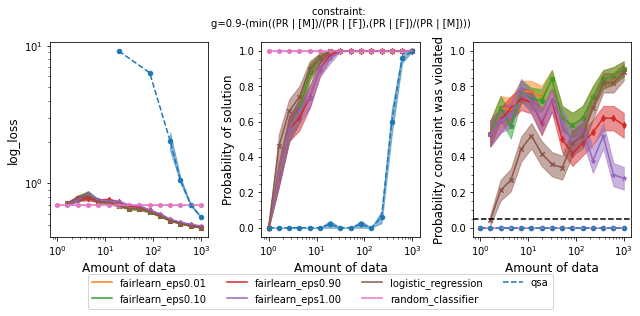

In [50]:
if make_plots:
  if save_plot:
      plot_generator.make_plots(fontsize=12,legend_fontsize=8,
          performance_label=performance_metric,
          performance_yscale='log',
          savename=plot_savename)
  else:
      plot_generator.make_plots(fontsize=12,legend_fontsize=8,
          performance_label=performance_metric,
          performance_yscale='log')

The three plots of the Seldonian Experiment we ran are shown above. The disparate impact fairness constraint, $g$, is written at the top of the figure. When $g\leq0$, the fairness constraint is satisfied. Each panel shows the mean (point) and standard error (shaded region) of a quantity as a function of the amount of data used to run the Seldonian algorithm (determined from the data fraction array) for several models: the quasi-Seldonian model (QSA, blue), the two baseline models: 1) a random classifier (pink) that predicts the positive class with $p=0.5$ every time and 2) a logistic regression model without any constraints added (brown), and a Fairlearn model with four different values of epsilon, the ratio bound. (Left) the logistic loss. (Middle) the fraction of trials that returned a solution. (Right) the fraction of trials that violated the safety constraint on the ground truth dataset. The black dashed line is set at the $\delta=0.05$ value that we set in our behavioral constraint.

The QSA takes more data to return a solution (middle panel) than the other models because it makes a high-confidence guarantee that the solution it returns will be safe. That guarantee is validated because the QSA never violates the fairness constraint on the ground truth dataset (right panel). The QSA's performance (left panel) approaches the performance of the logistic regression baseline as the number of training samples approaches 1000, the size of the original dataset. The logistic regression model and even the fairness-aware Fairlearn model return solutions with less data, but both violate the constraint quite often. This is true for all four values of the disparate impact threshold, epsilon, and despite the fact that Fairlearn is using a disparate impact constraint when training its models.

The fact that it takes the QSA all 1000 data points to return a solution with probability of 1.0 underscores that Seldonian algorithms often need a reasonable amount of data to return solutions. The precise amount of data needed will depend on the dataset and constraint(s), and determining that amount is one of the reasons to run a Seldonian Experiment. It just so happened in this case that the amount of data we had in our original dataset was enough for the Seldonian algorithm to return a solution every time. 

Some minor points to notice about these plots are:

*  The performance is not plotted for trials that did not return a solution. For the smallest data fractions (e.g., 0.001), only the random classifier returns a solution because it is defined to always return the same solution independent of input. 
*  The solution rate is between 0 and 1 for the logistic regression model and the Fairlearn models for small amounts of data, not 0 or 1 as one might expect. This happens because in each trial, at a fixed number of training samples, a different resampled dataset is used. When the number of training samples is small ($\lesssim 10$), some of these resampled datasets only contain data labeled for one of the two label classes, i.e., all 0s or all 1s. The logistic regression model and the Fairlearn models return an error when we attempt to train them on these datasets. We count those cases as *not* returning a solution. Note that Seldonian algorithms do not return a solution for a different reason. They do this when the algorithm deems that the solution is not safe. The random classifier does not use the input data to make predictions, which is why it always returns a solution. 
*  The failure rate is not plotted for trials that did not return a solution for all models except QSA. The logistic regression baseline and Fairlearn can fail to converge, for example. However, the QSA will always return either a solution or "NSF", even when only one data point (i.e., `data_frac=0.001`) is provided as input. In cases where it returns "NSF", that solution is considered safe.  
*  The random classifier does not violate the safety constraint ever because its positive rate is 0.5 for all datapoints, regardless of sex/gender.

<a name="modifying_the_constraint"></a>
## Modifying the constraint to line up with Fairlearn's constraint
We mentioned that Fairlearn cannot exactly enforce the disparate impact constraint we defined: $\text{min}( (\text{PR} | [\text{M}]) / (\text{PR} | [\text{F}]), (\text{PR} | [\text{F}]) / (\text{PR} | [\text{M}]) ) \geq 0.9$. This is because Fairlearn's <a href="https://fairlearn.org/v0.7.0/user_guide/mitigation.html#fairness-constraints-for-binary-classification">fairness constraints for binary classification</a> only compare statistics like positive rate between a single group (such as "male") in a protected class (such as gender) and the mean of all groups in that class. The Seldonian Engine is flexible in how its constraints can be defined, and we can tweak our disparate impact constraint definition to match the Fairlearn definition. To match the Fairlearn definition, our constraint must take the form: $\text{min}( (\text{PR} | [\text{M}]) / (\text{PR}), (\text{PR}) / (\text{PR} | [\text{M}]) ) \geq 0.9$, where the only thing we have changed from our original constraint is substituting $(\text{PR} | [\text{F}])$ (positive rate, given female) in our original constraint for $(\text{PR})$, the mean positive rate. 

Let us rerun the same experiment above with this new constraint. First, we need to create a new spec file, where the only difference is the constraint definition. This will build a new parse tree from the new constraint. Replace the line above:

In [ ]:
# Define behavioral constraints
constraint_strs = ['min((PR | [M])/(PR | [F]),(PR | [F])/(PR | [M])) >= 0.9']

with:

In [ ]:
constraint_strs = ['min((PR | [M])/(PR),(PR)/(PR | [M])) >= 0.9']

Then, change the line where the spec file is saved so it does not overwrite the old spec file from:

In [ ]:
spec_save_name = 'spec_fairlearndef.pkl'

Once that file is saved, you are ready to run the experiments again. There are only a few changes you will need to make to the above code. They are:

*  Set `fairlearn_eval_method = "native"`.
*  Set `fairlearn_epsilons_constraint = [0.9]`.
*  Point `specfile` to the new spec file you just created.
*  Change `results_dir` to a new directory so you do not overwrite the results from the previous experiment. 

Running the above with these changes will produce a plot that looks like this:


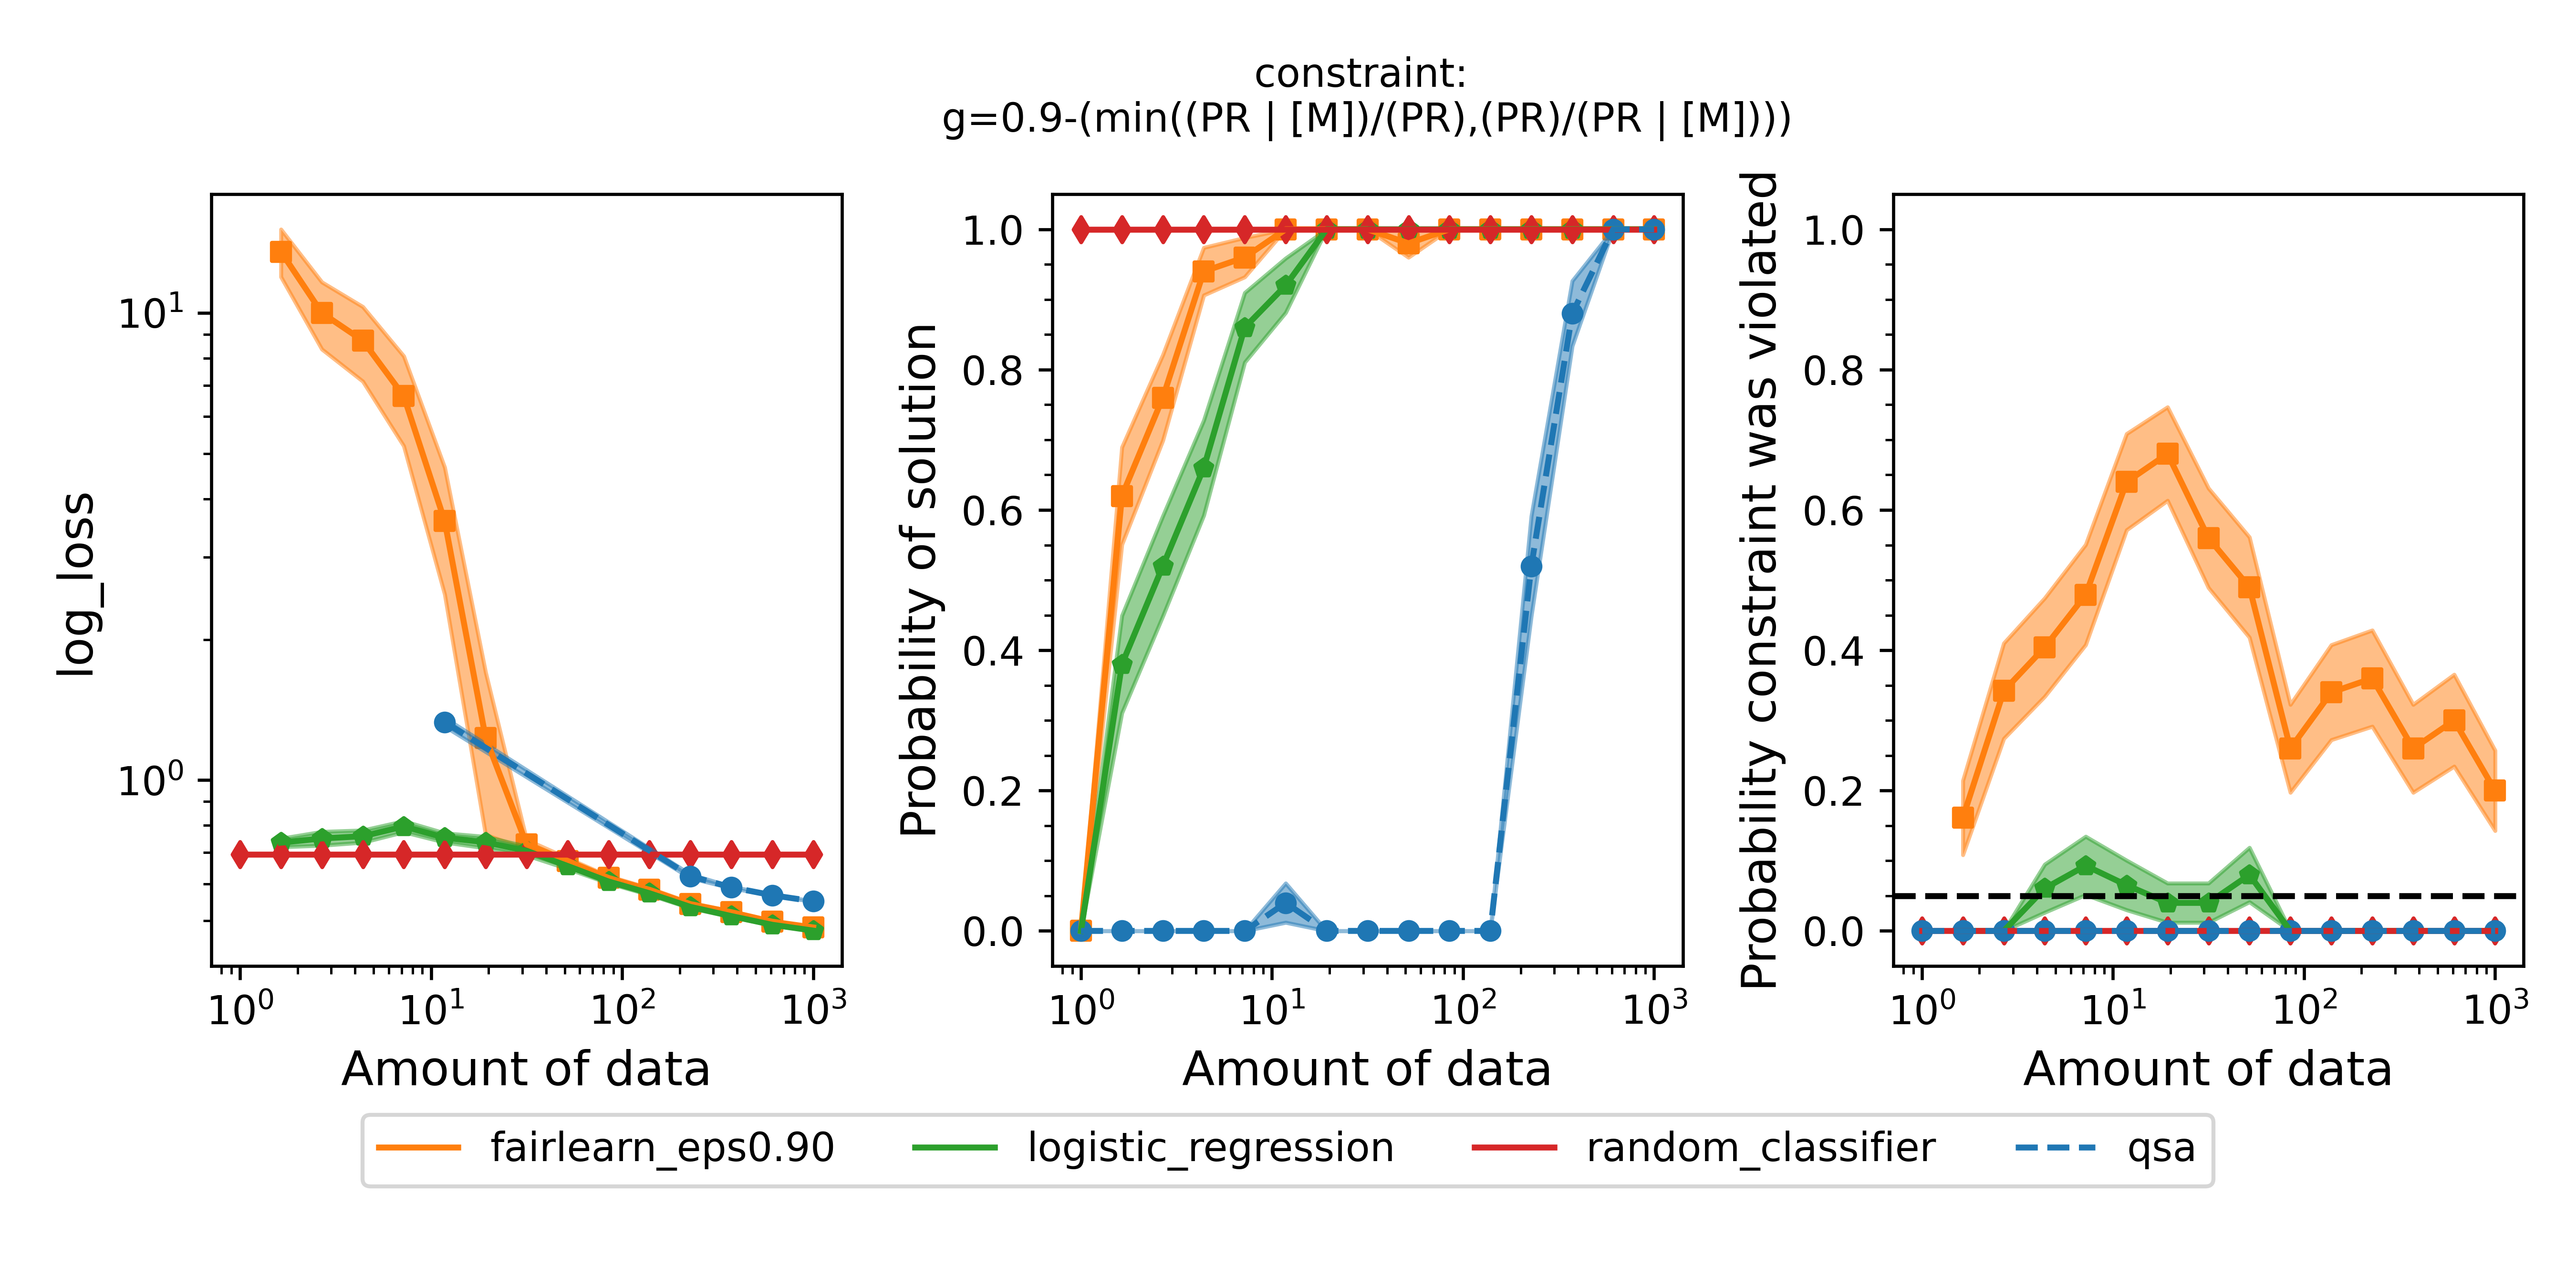

The above figure has the same layout as the previous experimental figure but with the definition of disparate impact that Fairlearn uses, i.e., $\text{min}( (\text{PR} | [\text{M}]) / (\text{PR}), (\text{PR}) / (\text{PR} | [\text{M}]) ) \geq 0.9$. In this experiment, we used a single Fairlearn model with $\epsilon=0.9$ because the constraint was identical to the constraint used in the QSA model, which was not true in the previous set of experiments.

The results are very similar to the previous experiments. As before, the QSA takes more data than the baselines and Fairlearn to return solutions, but those solutions are safe. The solutions from the Fairlearn model are frequently unsafe. Interestingly, the logistic model is not as unsafe for this definition of disparate impact as it was for the previous definition.

We could use the same procedure we just carried out to change the fairness definition entirely. For example, another common definition of fairness is equalized odds, which ensures that the false positive rates and false negative rates simultaneously do not differ within a certain tolerance. Let's define the constraint string that the engine can understand: $\text{abs}((\text{FPR} | [\text{M}]) - (\text{FPR} | [\text{F}])) + \text{abs}((\text{FNR} | [\text{M}]) - (\text{FNR} | [\text{F}])) \leq 0.2$. Repeating the same procedure as above to replace the constraint with this one and create a new spec file, the only changes we need to make to the experiment script are:



In [ ]:
constraint_name = 'equalized_odds'
fairlearn_constraint_name = constraint_name
fairlearn_epsilon_eval = 0.2 # the epsilon used to evaluate g, needs to be same as epsilon in our definition
fairlearn_eval_method = 'two-groups' # the epsilon used to evaluate g, needs to be same as epsilon in our definition
fairlearn_epsilons_constraint = [0.01,0.1,0.2,1.0] # the epsilons used in the fitting constraint

We also need to point to the new spec file we created for the new constraint. Running the experiment for this constraint, we obtain the following figure: 

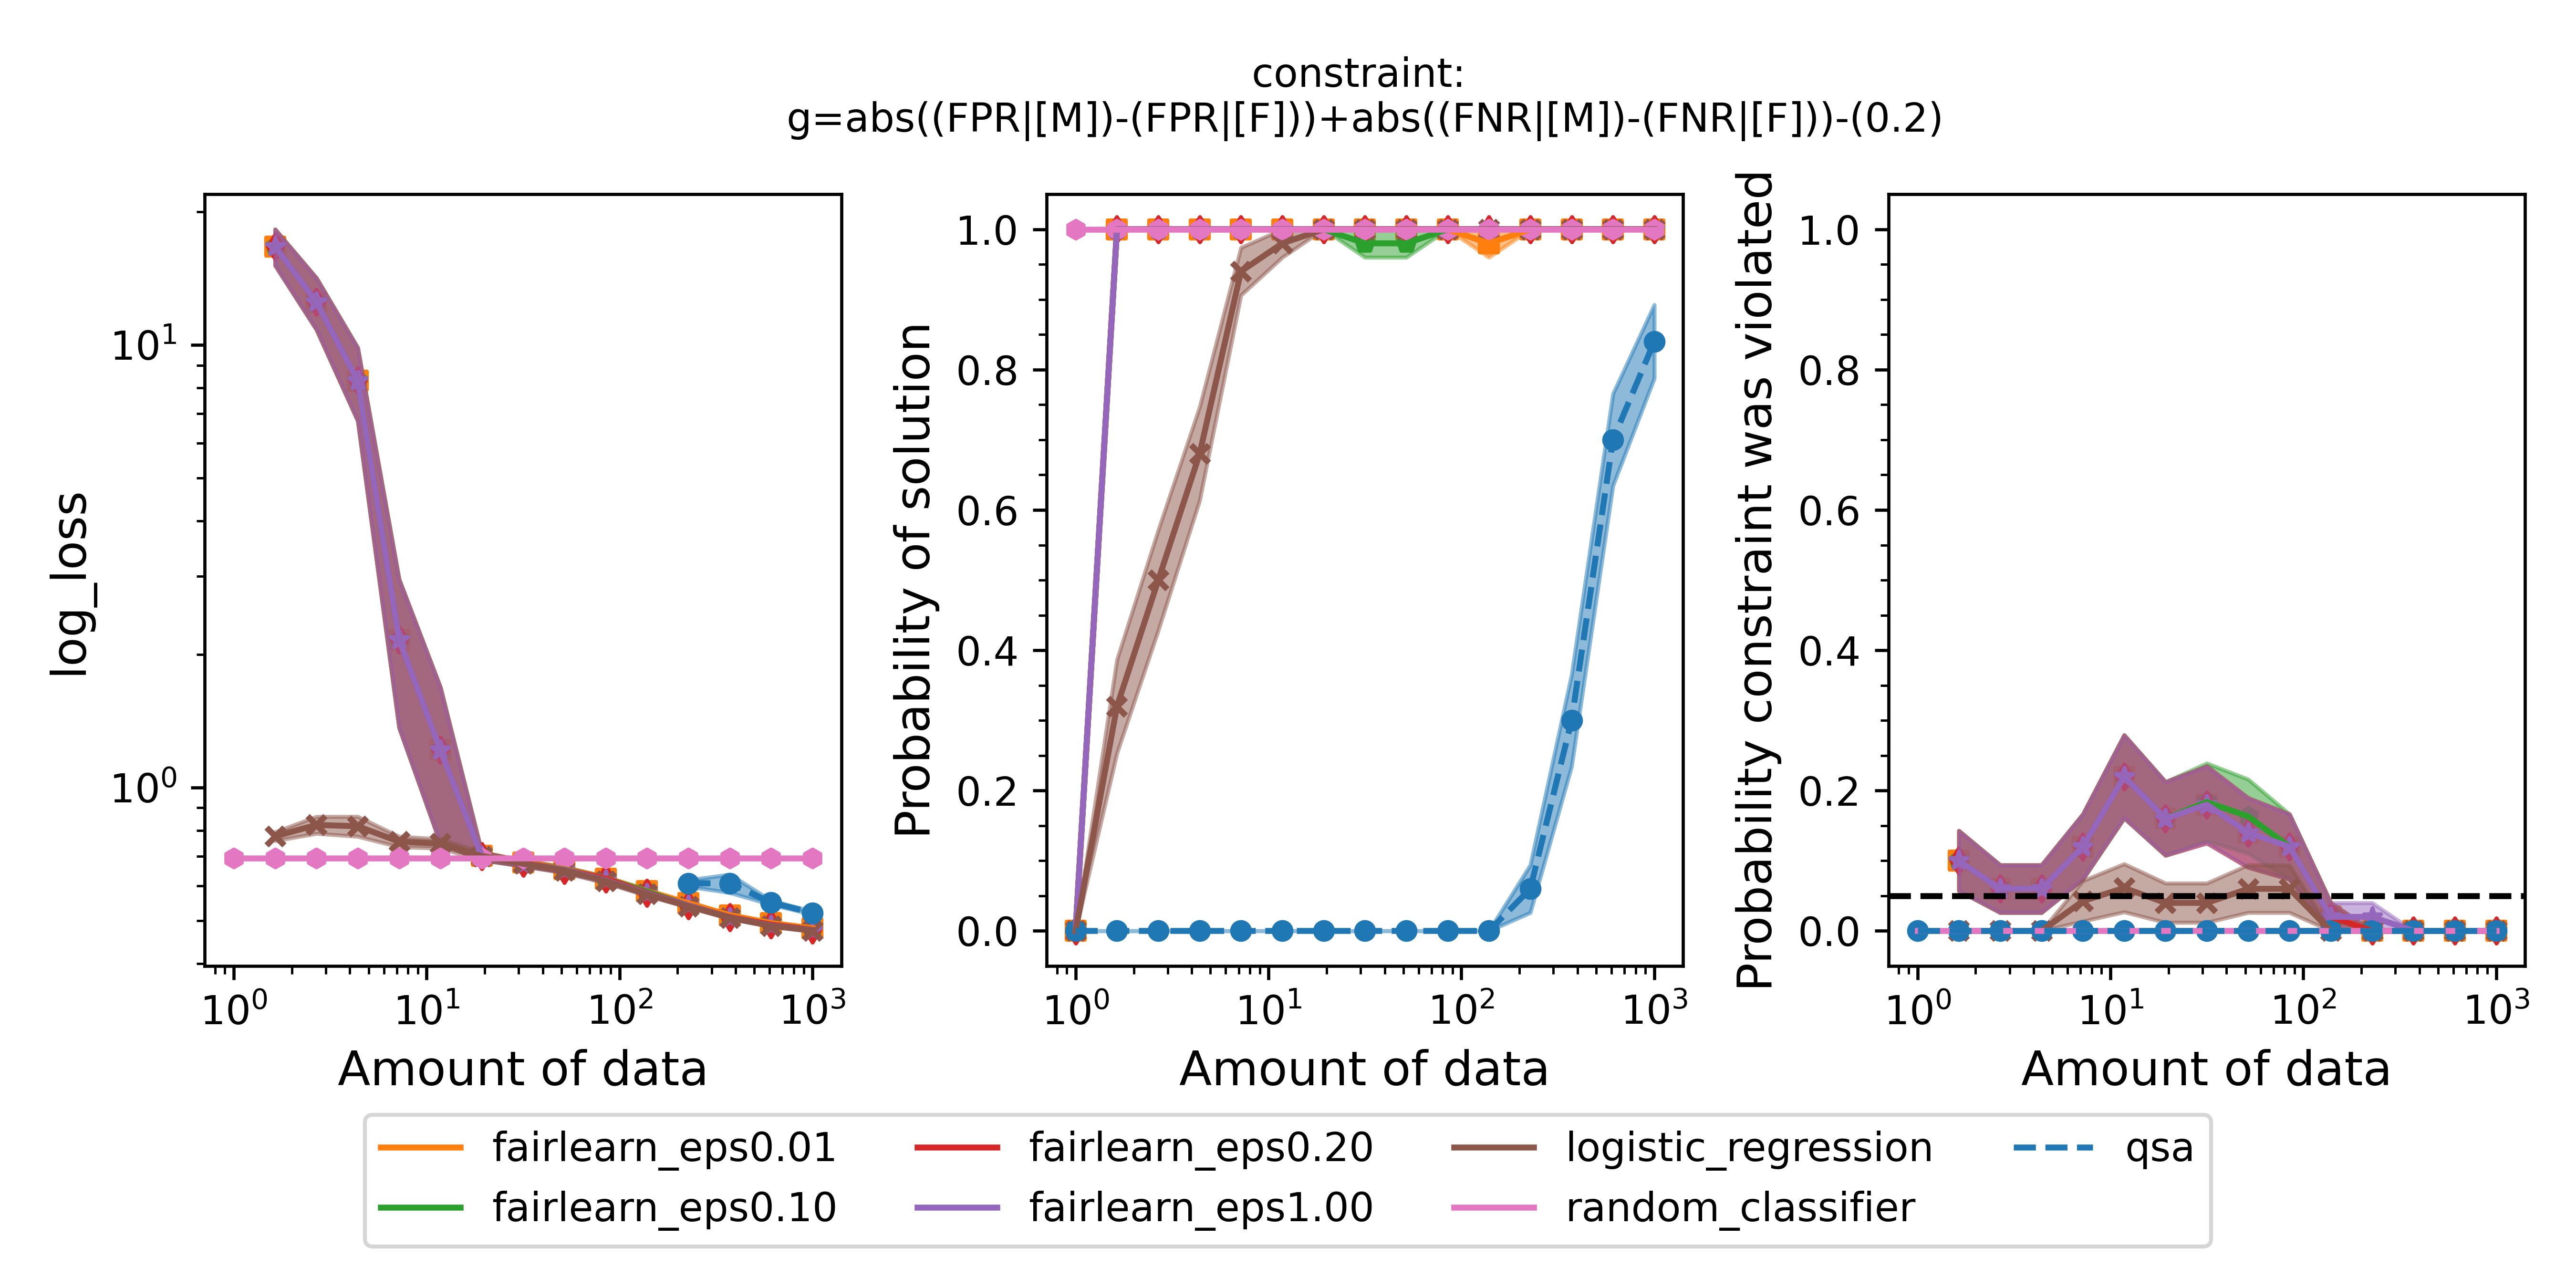

The conclusions we can draw from this figure are similar to the ones we drew from the last one. In this case, it takes a bit more data to start getting solutions for the QSA. The performance of the QSA again approaches that of the logistic regression model. As before, the QSA is safe on the ground truth data, whereas the baselines and fairlearn are not always safe. 

<a name="summary"></a>
## Summary
In this tutorial, we demonstrated how to use the Seldonian Toolkit to build a predictive model that enforces a variety of fairness constraints on the German Credit dataset. We covered how to format the dataset and metadata so that they can be used by the Seldonian Engine. Using the engine, we ran a Seldonian algorithm and confirmed that we were able to find a safe solution. We then ran a serires of Seldonian Experiments to evaluate the true performance and safety of our quasi-Seldonian algorithm (QSA) using different fairness definitions.